# Статистика по интересам
- вероятности инсталла по интересам
- вероятности инсталла по интересам и приложениям (на выборке большего размера за сутки)
---
- для выделения интересов жинрым шрифтом на графике statter, добавляю тег ```<b>...</b>``` прямо в наименование интереса в DataFrame
- чтобы выровнить надпись по левому краю в bar добавляю выравниваю и смещаю начало отрисовки баров ближе к центру

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from io import StringIO

## interests
ClickHouse https://redash.trg.corp.mail.ru/queries/28482/source

In [2]:
interests_path = '/home/eka.volkova/TRG-91593_interests_statistics/interests_statistics/interests_all_targeting_id.csv' # все target_id
# interests_path = '/home/eka.volkova/TRG-90187_age_means/interests.csv' # target_id = 5
# Беру интересы со всеми target_id, если брать только target_id=5, то почти 74% интересов не заполнено

interests = pd.read_csv(interests_path)

In [3]:
interests.rename(columns={'value': 'interests', 'description': 'interest_name'}, inplace=True)
interests['interests'] = interests['interests'].astype('str')
interests.set_index('interests', inplace=True)

In [4]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 719 entries, 7354 to 10015
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   interest_name  719 non-null    object
dtypes: object(1)
memory usage: 11.2+ KB


In [5]:
interests.head()

,interest_name
interests,
7354,Авто / Автовладельцы
7358,Мобильные устройства / Сотовые телефоны и гарн...
7359,Мобильные устройства / Планшеты и электронные ...
7360,Мобильные устройства / Ноутбуки и нетбуки
7361,"Одежда, обувь и аксессуары / Женская одежда"


# show_installs за 1 день

In [6]:
orig_data_path = '/home/eka.volkova/TRG-90187_age_means/orig_data/show_install/'

In [7]:
csv_files = [f for f in listdir(orig_data_path) if (isfile(join(orig_data_path, f)) and f.find('.csv') != -1)]
csv_files.sort()

In [8]:
csv_files

['show_install_20221107002350.csv',
 'show_install_20221107022320.csv',
 'show_install_20221107041600.csv',
 'show_install_20221107062340.csv',
 'show_install_20221107082340.csv',
 'show_install_20221107102248.csv',
 'show_install_20221107122410.csv',
 'show_install_20221107142450.csv',
 'show_install_20221107162310.csv',
 'show_install_20221107182117.csv',
 'show_install_20221107202430.csv',
 'show_install_20221107222240.csv',
 'show_install_20221108002400.csv',
 'show_install_20221108022420.csv',
 'show_install_20221108041910.csv',
 'show_install_20221108062400.csv',
 'show_install_20221108082440.csv',
 'show_install_20221108101855.csv',
 'show_install_20221108122930.csv',
 'show_install_20221108142320.csv',
 'show_install_20221108162250.csv',
 'show_install_20221108182400.csv',
 'show_install_20221108202240.csv',
 'show_install_20221108222410.csv',
 'show_install_20221109002450.csv',
 'show_install_20221109022530.csv',
 'show_install_20221109042030.csv',
 'show_install_2022110906235

In [9]:
len(csv_files)

120

In [10]:
len([file for file in csv_files if file[19:21] in ('07')])

12

## Читаем файлы в DataFrame

In [11]:
# show_install_20221107*.csv
show_install = \
pd.concat([pd.read_csv(f'{orig_data_path}{file}', sep=';') for file in [file for file in csv_files if file[19:21] in ('07')]], ignore_index=True) 

In [12]:
show_install.shape

(159005975, 11)

In [13]:
show_install.replace(to_replace={'ev_type': 7}, value=1, inplace=True)
show_install['ev_type'].value_counts()

0    152731803
1      6274172
Name: ev_type, dtype: int64

In [14]:
show_install['ev_type'].value_counts().sum()

159005975

In [15]:
show_install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159005975 entries, 0 to 159005974
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   age               float64
 1   age_targetings    int64  
 2   app               int64  
 3   ev_type           int64  
 4   has_interest      int64  
 5   iab_app_category  object 
 6   interests         int64  
 7   matched_bits      int64  
 8   rb_mobile_app_id  int64  
 9   sex               int64  
 10  timestamp         int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 13.0+ GB


## Добавляем расшифровку interests

In [ ]:
show_install['interests'] = show_install['interests'].astype('str')
show_install = show_install.join(interests['interest_name'], on='interests')
show_install.fillna(value={'interest_name': 'Не определено'}, inplace=True)
show_install['interest_name'].value_counts()

In [ ]:
show_install[show_install['interest_name'].isna()].shape[0]

In [ ]:
show_install.head()

## Вероятность инсталла по интересам

In [ ]:
show_install_interests = show_install.copy()[['interest_name', 'ev_type']]
show_install_interests = show_install_interests.groupby(by='interest_name')['ev_type'].mean().rename('cr')
show_install_interests.sort_values(ascending=False, inplace=True)
show_install_interests.head()

## Добавляем график Toп интересов

In [ ]:
# import plotly.express as px
import plotly.graph_objects as go

In [ ]:
top = 30
df_bar = show_install_interests.head(top).sort_values().reset_index()

fig = \
go.Figure(
    data=go.Bar(
        x=df_bar['cr'], y=df_bar['interest_name'], 
        orientation='h'),
    layout=go.Layout(
        title='Топ интересов', 
        xaxis={'domain': [0.45, 1]}, 
        yaxis={'anchor': 'free', 'position': 0, 'side': 'right'}, 
        height=20*top)
)

fig.show()

---
# Top интересов по приложениям

## Находим топ приложений по CR и определяем топ интересов для них

### CR по приложениям

In [ ]:
show_install_app = show_install.copy()[['interest_name', 'ev_type', 'app']]

# Количество инсталлов по приложениям должно быть хотя бы от 5 и показов от 100 
show_install_app = \
show_install_app.groupby(by='app').agg(
    shows=pd.NamedAgg(column='ev_type', aggfunc='count'), 
    installs=pd.NamedAgg(column='ev_type', aggfunc='sum'), 
    cr=pd.NamedAgg(column='ev_type', aggfunc='mean')
).query('shows + installs >= 100 and installs >= 5')

show_install_app.sort_values(by=['cr', 'installs'], ascending=[False, False], inplace=True)

In [ ]:
show_install_app.head()

### CR по приложениям и интересам

In [ ]:
show_install_app_interest = show_install.copy()[['interest_name', 'ev_type', 'app']]

show_install_app_interest = \
show_install_app_interest.groupby(by=['app', 'interest_name']).agg(
    shows=pd.NamedAgg(column='ev_type', aggfunc='count'), 
    installs=pd.NamedAgg(column='ev_type', aggfunc='sum'), 
    cr=pd.NamedAgg(column='ev_type', aggfunc='mean')
)
show_install_app_interest.reset_index(level='interest_name', inplace=True)
show_install_app_interest.sort_values(by='cr', ascending=False, inplace=True)

In [ ]:
show_install_app_interest.head()

## Объединяем рейтинг приложений с рейтингом интересов внутри приложения

In [ ]:
# Выбираем Топ N приложений по CR 
top_show_install_app = 100 # количество приложений
show_install_top_app_interest = show_install_app.head(top_show_install_app)

# Отбираем по уровню CR
# show_install_top_app_interest = show_install_app[show_install_app['cr'] == 1]

# Топ приложений с НЕ 100% CR
# show_install_top_app_interest = show_install_app[show_install_app['cr'] != 1].head(top_show_install_app)

In [ ]:
show_install_top_app_interest = \
show_install_top_app_interest.iloc[:, :-4].\
join(show_install_app_interest, on='app').query('cr > 0.0')
show_install_top_app_interest.reset_index(inplace=True)

In [ ]:
show_install_top_app_interest.head()

In [ ]:
top_interest=15 # Количество интересов в рамках одного приложения
show_install_top_app_interest = show_install_top_app_interest.groupby(by='app').head(top_interest)

In [ ]:
show_install_top_app_interest.head()

In [ ]:
show_install_top_app_interest.shape

## Добавляем расшифровку app
Получаем список приложений, которые есть в обучающей выборке и выгружаем их из ClichHouse https://redash.trg.corp.mail.ru/queries/28422/source

In [ ]:
app_path = '/home/eka.volkova/TRG-91593_interests_statistics/interests_statistics/app.csv'
app = pd.read_csv(app_path)

app.rename(columns={'rb_mobile_app_id': 'app', 'title': 'app_name'}, inplace=True)
app.set_index('app', inplace=True)
app.head()

In [ ]:
show_install_top_app_interest = show_install_top_app_interest.join(app, on='app')

In [ ]:
show_install_top_app_interest.head()

# Добавляем график по интересам и приложениям

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df_scatter = show_install_top_app_interest.copy()
# Выделяем жирным шрифтом интересы, которые были в общем Топе
df_scatter['interest_name'] = df_scatter.apply(lambda row: '<b>' + row['interest_name'] + '</b>' if (row['app'] in df_bar['interest_name']) else row['interest_name'], axis=1)

In [ ]:
df_scatter.head()

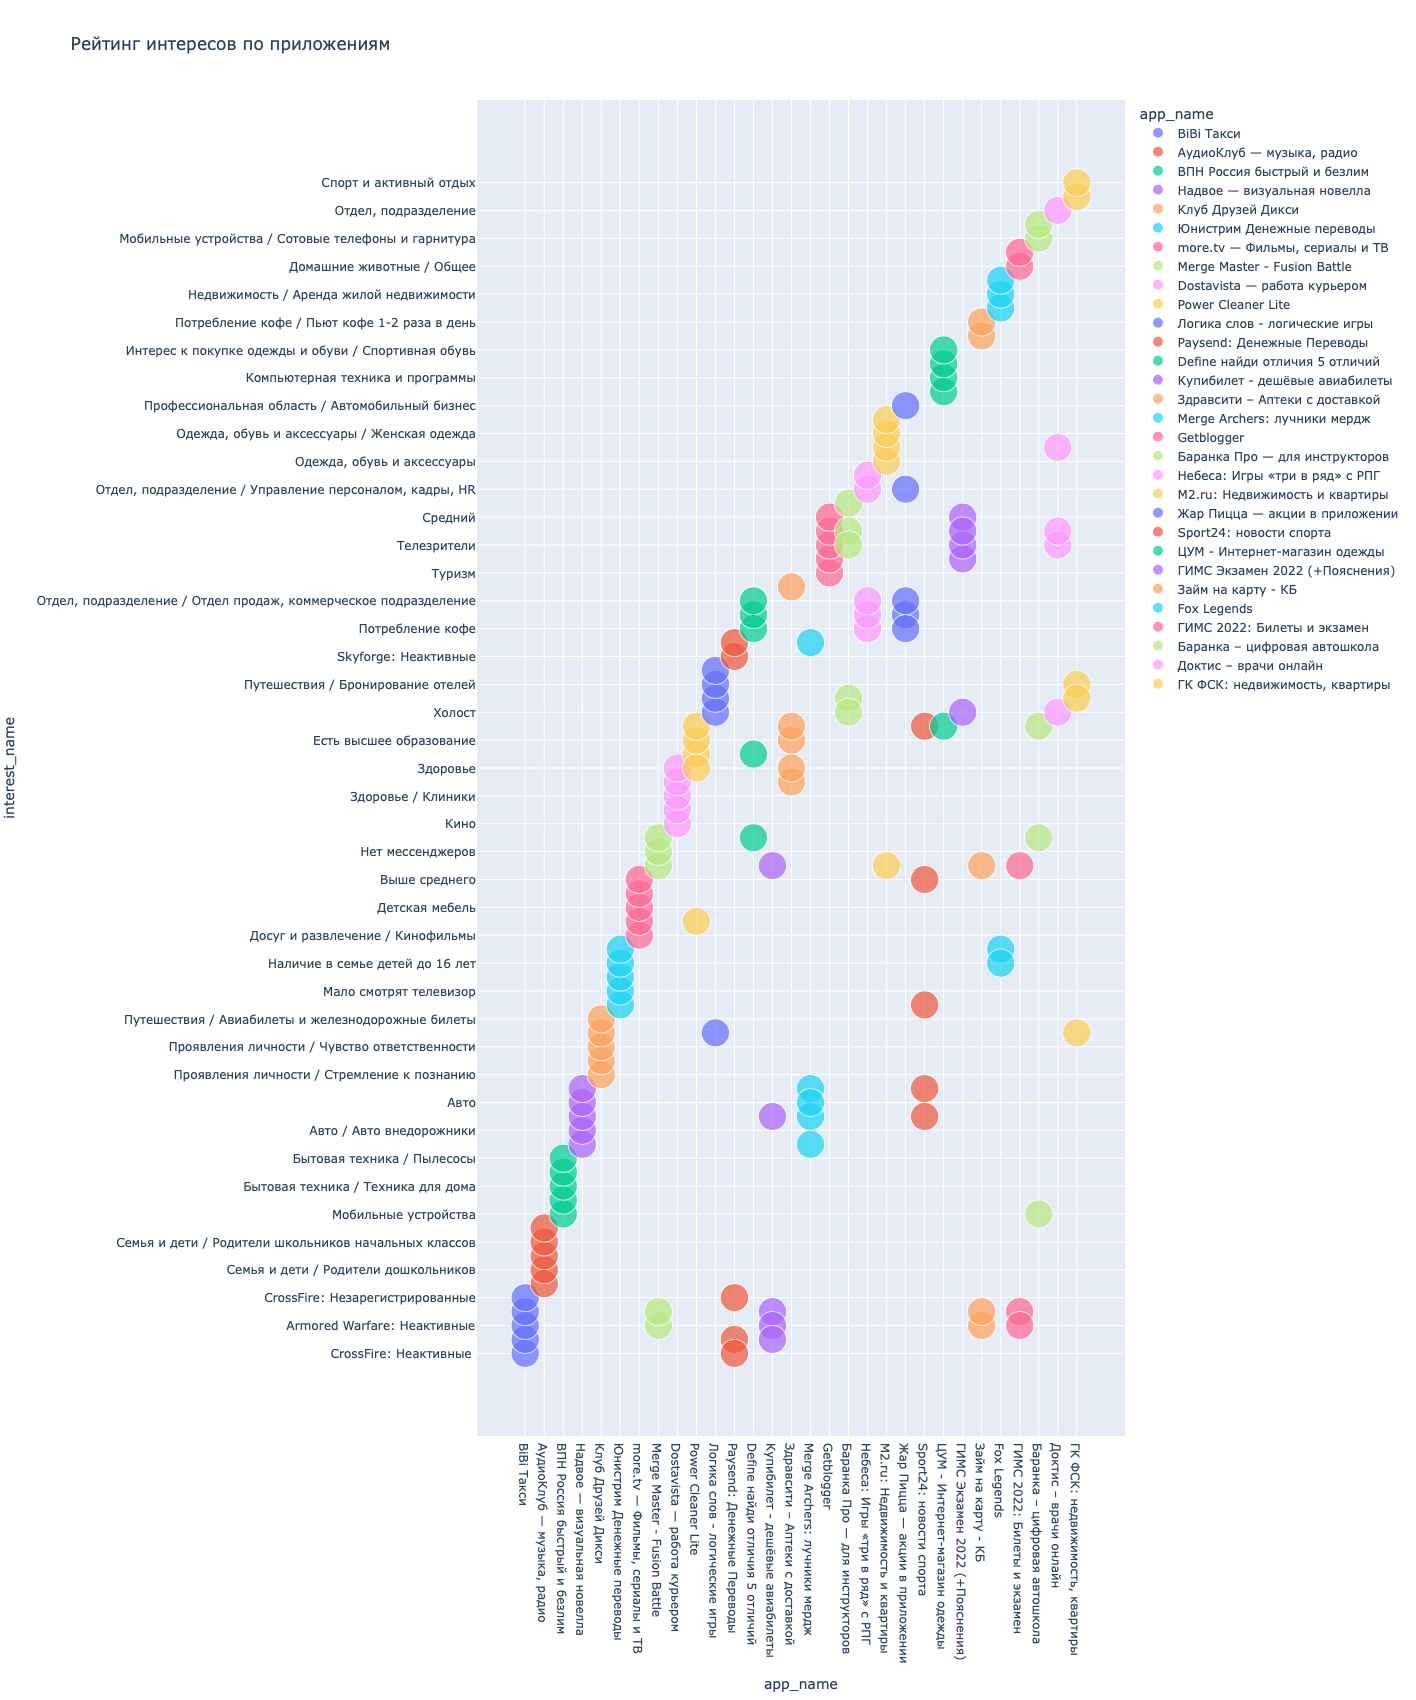

In [303]:
fig = px.scatter(
    df_scatter, x="app_name", y="interest_name", 
    color="app_name",size='cr', height = 20*show_install_top_app_interest['interest_name'].nunique(), 
    title='Рейтинг интересов по приложениям')
fig.show()